In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Load the breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Feature names: {cancer.feature_names[:5]}...")  # Show first 5 features
print(f"Target names: {cancer.target_names}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (569, 30)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...
Target names: ['malignant' 'benign']
Class distribution: [212 357]


Missing values: 0

Feature statistics:
                                min         max        mean         std
mean radius                6.981000    28.11000   14.127292    3.524049
mean texture               9.710000    39.28000   19.289649    4.301036
mean perimeter            43.790000   188.50000   91.969033   24.298981
mean area                143.500000  2501.00000  654.889104  351.914129
mean smoothness            0.052630     0.16340    0.096360    0.014064
mean compactness           0.019380     0.34540    0.104341    0.052813
mean concavity             0.000000     0.42680    0.088799    0.079720
mean concave points        0.000000     0.20120    0.048919    0.038803
mean symmetry              0.106000     0.30400    0.181162    0.027414
mean fractal dimension     0.049960     0.09744    0.062798    0.007060
radius error               0.111500     2.87300    0.405172    0.277313
texture error              0.360200     4.88500    1.216853    0.551648
perimeter error          

<Figure size 1200x800 with 0 Axes>

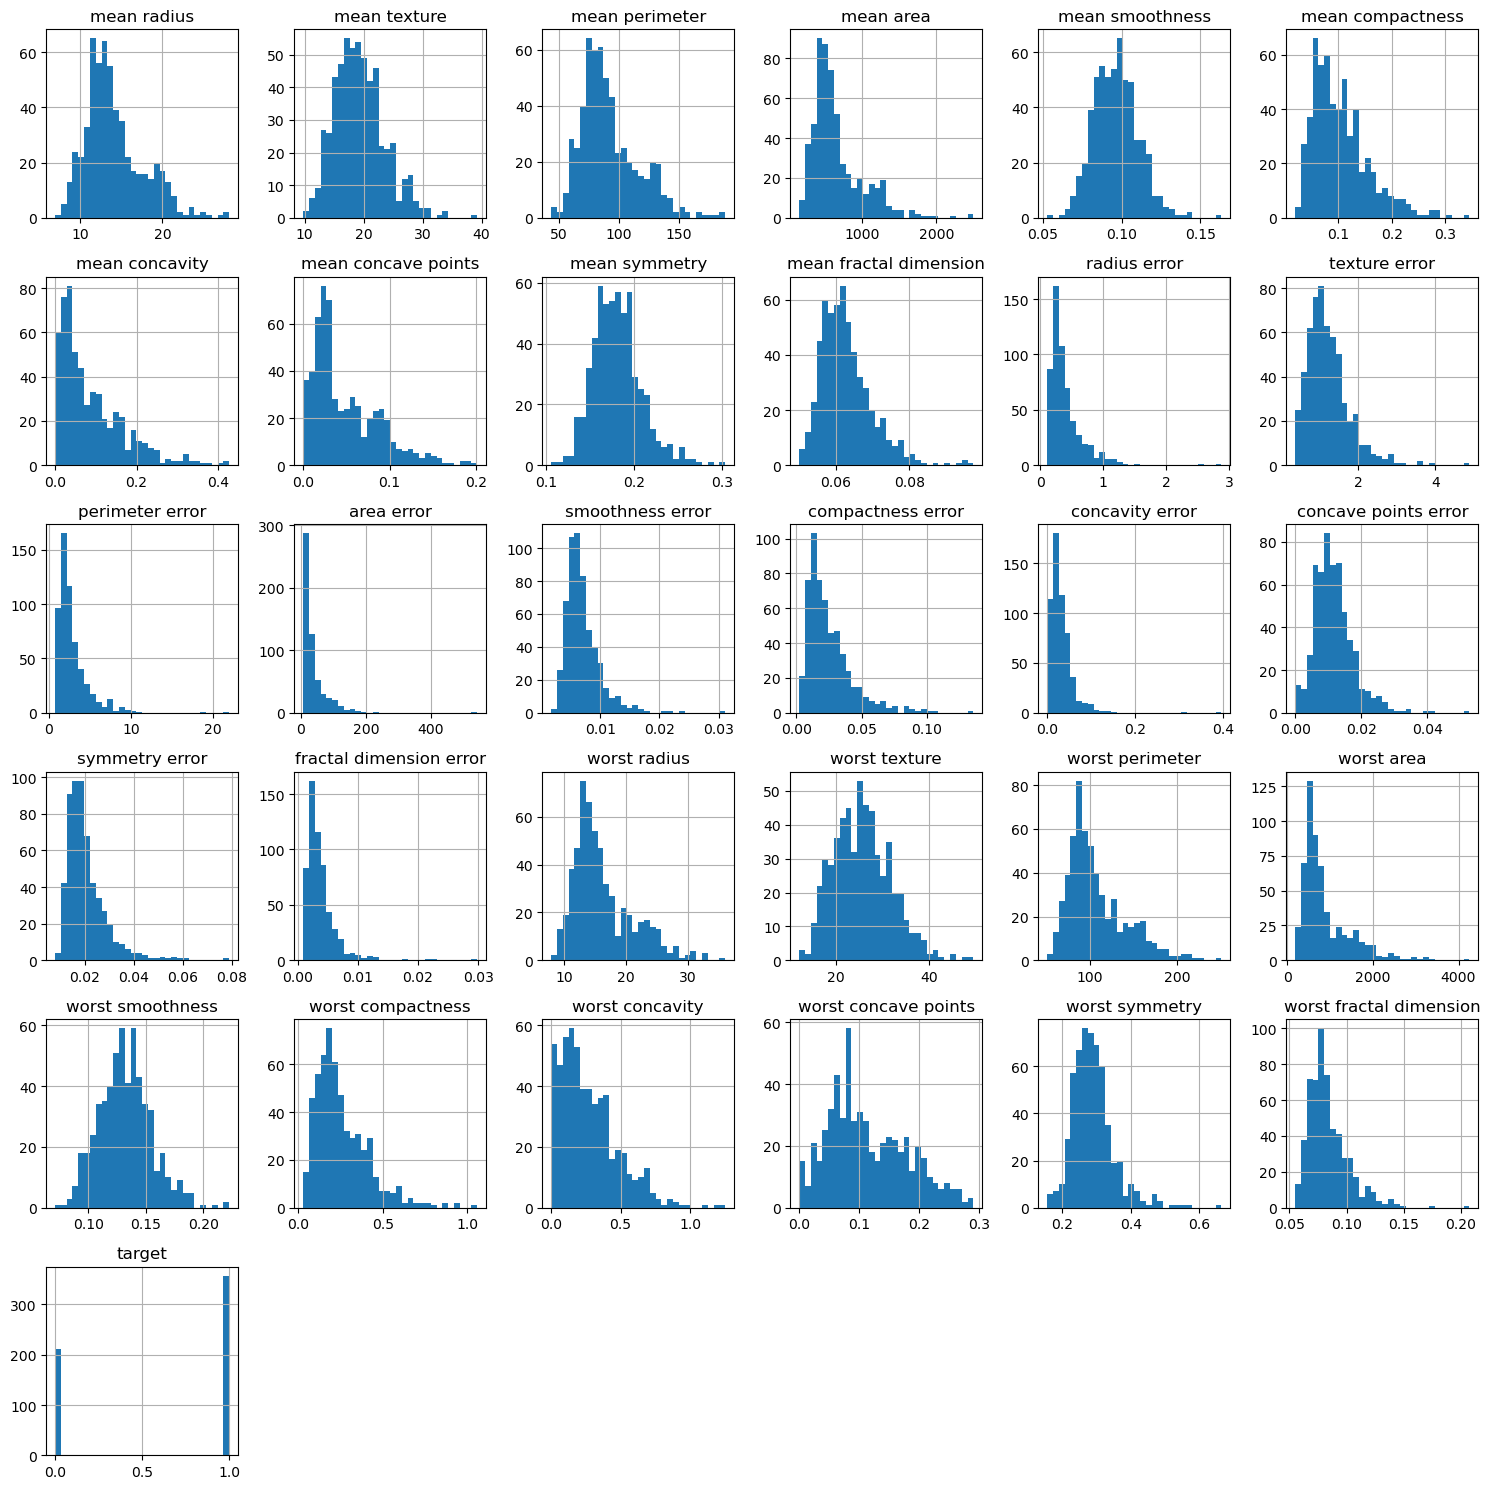

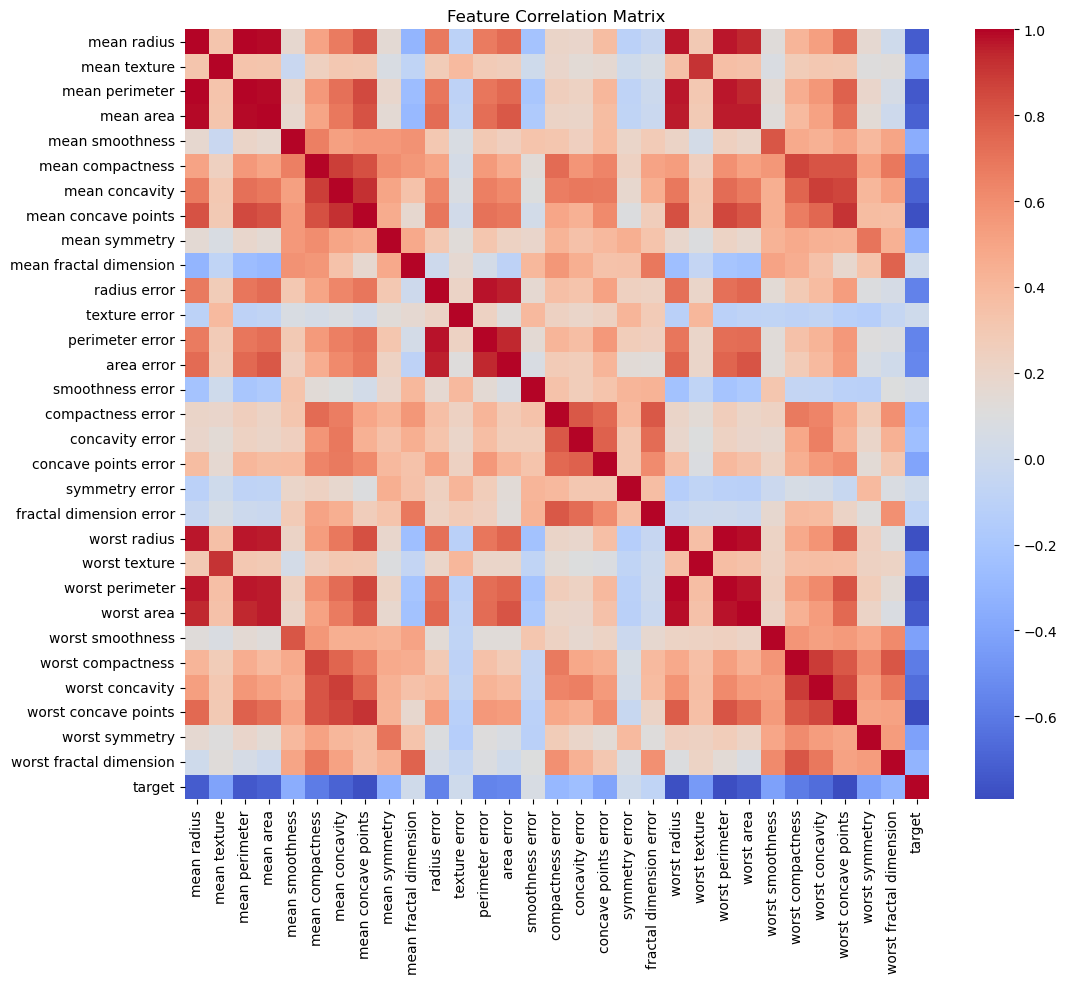

In [2]:
# Create a DataFrame for easier analysis
df = pd.DataFrame(X, columns=cancer.feature_names)
df['target'] = y

# Check for missing values
print(f"Missing values: {df.isnull().sum().sum()}")

# Look at feature statistics
print("\nFeature statistics:")
print(df.describe().T[['min', 'max', 'mean', 'std']])

# Visualize feature distributions
plt.figure(figsize=(12, 8))
df.hist(figsize=(15, 15), bins=30)
plt.tight_layout()
plt.show()

# Check for feature correlations
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to have zero mean and unit variance
# This is crucial for distance-based algorithms to prevent features with larger scales from dominating
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Calculate covariance matrix for Mahalanobis distance
cov = np.cov(X_train_scaled, rowvar=False)

# Define parameter grid for standard metrics
param_grid = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and score
standard_best_params = grid_search.best_params_
standard_best_score = grid_search.best_score_
print(f"Best parameters (standard metrics): {standard_best_params}")
print(f"Best cross-validation accuracy: {standard_best_score:.4f}")

# For Mahalanobis, we need a special setup
# Create a custom object to include covariance matrix as special parameter
knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params={'VI': cov})

# Parameters for Mahalanobis
param_grid_mahalanobis = {
   'n_neighbors': list(range(1, 31, 2)),
   'weights': ['uniform', 'distance'],
   'algorithm': ['auto']
}

# Perform grid search for Mahalanobis
print("\nStarting grid search for Mahalanobis metric...")
grid_search_mahalanobis = GridSearchCV(knn_mahalanobis, param_grid_mahalanobis, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_mahalanobis.fit(X_train_scaled, y_train)

# Get best parameters and score
mahalanobis_best_params = grid_search_mahalanobis.best_params_
mahalanobis_best_score = grid_search_mahalanobis.best_score_
print(f"Best parameters (Mahalanobis): {mahalanobis_best_params}")
print(f"Best cross-validation accuracy: {mahalanobis_best_score:.4f}")

# Determine overall best model
best_scores = {
    'Standard': (standard_best_score, standard_best_params),
    'Mahalanobis': (mahalanobis_best_score, mahalanobis_best_params)
}

best_model_type = max(best_scores, key=lambda k: best_scores[k][0])
best_score = best_scores[best_model_type][0]
best_params = best_scores[best_model_type][1]

print(f"\nOverall best model: {best_model_type}")
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9648

Starting grid search for Mahalanobis metric...
Best parameters (Mahalanobis): {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy: 0.9670

Overall best model: Mahalanobis
Best parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy: 0.9670



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



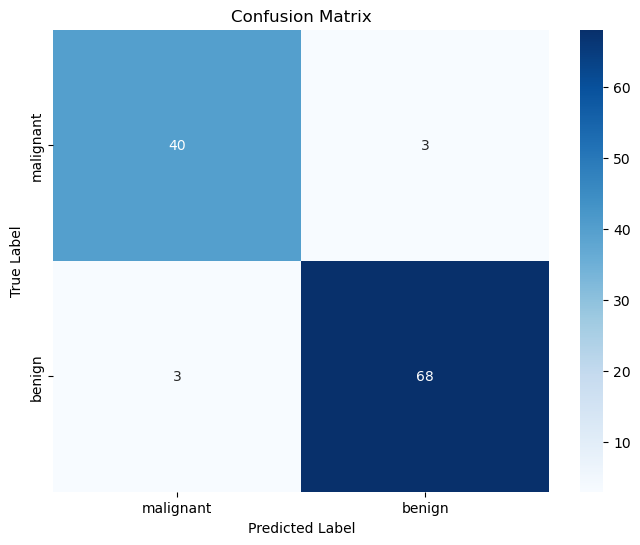

In [5]:
# Build the final model with the best parameters
final_model = grid_search_mahalanobis.best_estimator_


# Make predictions on test set
y_pred = final_model.predict(X_test_scaled)


# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print("\nClassification Report:")
print(class_report)


# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=cancer.target_names,
           yticklabels=cancer.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()